In [1]:
"""This is my first attempt to put together a ConvNet without using TensorFlow or Keras"""
"""
This program uses ConvNet to learn to recognize images of hand gestures showing numbers. 
There are 1080 x 64 x 64 x 3 training set. Here I used 3 conv net layers and 3 dense/FC layers
Output is softmax. I tried to vectorize as much as I could so that the progam runs faster.
contact: samuelpun@gmail.com
"""

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as Image
import random
import json
import time

#%matplotlib inline
#plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%precision 30

#np.random.seed(3) #FC_dW2 -> 4

'%.30f'

In [2]:
def yToVector(y, C=6):
    # convert the Y value into a vector of dimension C x 1
    m = y.shape[0]
    y = np.eye(6)[y].T.reshape(C,m) 
    #each row of eye matrix corresponds to the row vector of Y and [Y} specify which row to take
    #and then transpose it to a column vector and reshape it
    return y

In [3]:
def loadData ():
    # Training data
    #read for h5 datafile and convert into dictionary
    train_dataset = h5py.File('convdata/train_signs.h5', 'r')
    #for keys in test_dataset: print(keys) #print all the keys from the dict var
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_x_orig = train_set_x_orig/255 #normalize X
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    train_set_y_orig = yToVector(train_set_y_orig) #vectorize y
    list_classes = np.array(train_dataset["list_classes"][:]) # your train set labels  
    
    # Test Data
    test_dataset = h5py.File('convdata/test_signs.h5', 'r')
    #for keys in test_dataset: print(keys) #print all the keys from the dict var
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your train set features
    test_set_x_orig = test_set_x_orig/255 #normalize X
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your train set labels
    test_set_y_orig = yToVector(test_set_y_orig) #vectorize y 
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, list_classes

In [4]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) 
    # number of mini batches of size mini_batch_size in your partitionning
    
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size : (k+1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(num_complete_minibatches * mini_batch_size) : m,:,:,:]
        mini_batch_Y = shuffled_Y[:,(num_complete_minibatches * mini_batch_size) : m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [213]:
def showActivationPortion(activateArray, params):
    noOfAct = 9
    ImagePortionList = []
    
    for i in range(noOfAct):
        m, nH, nW, nC = activateArray[0]['CN_A2'].shape
        maxarg = np.argmax(activateArray[0]['CN_A2'], axis=0)
        neuro_pos = (random.randint(0,nH-1),random.randint(0,nW-1))
        max_sample = maxarg[neuro_pos[0],neuro_pos[1],0]

        #calculate the corresponding pos in pool 1
        f, f, nC_prev, nC = params['CN_W2'].shape
        p = params['hparam_conv2']['pad']
        s = params['hparam_conv2']['stride']
        conv2_vstart = neuro1[0]*s
        conv2_vend = neuro1[0]*s+f
        conv2_hstart = neuro1[1]*s
        conv2_hend = neuro1[1]*s+f
        #print(conv2_hend-conv2_hstart)

        #calculate the corresponding pos in conv 1
        f = params['hparam_pool1']['f']
        s = params['hparam_pool1']['stride']

        pool1_vstart = conv2_vstart*s
        pool1_vend = conv2_vend*s
        pool1_hstart = conv2_hstart*s
        pool1_hend = conv2_hend*s

        #print(pool1_vend-pool1_vstart)

        #calculate the corresponding pos in input image
        f, f, nC_prev, nC = params['CN_W1'].shape
        p = params['hparam_conv1']['pad']
        s = params['hparam_conv1']['stride']
        conv1_vstart = pool1_vstart*s
        conv1_vend = pool1_vend*s+f
        conv1_hstart = pool1_hstart*s
        conv1_hend = pool1_hend*s+f
        #print(conv1_hend-conv1_hstart)

        input_padded = addPadding(test_x_orig, p)
        imageportion = input_padded[max_sample,conv1_vstart:conv1_vend,conv1_hstart:conv1_hend,:]
        ImagePortionList.append(imageportion)
    
    fig, axarr = plt.subplots(3, 3,  figsize=(6, 6))

    for i in range(noOfAct):
        rowth = int(i/3)
        colth = i - rowth*3
        #print(rowth)
        #print(colth)
        axarr[rowth,colth].imshow(ImagePortionList[i])
    plt.show()

    return


In [5]:
def showFilters(params, key='CN_W1'):
    
    p = params[key]
    
    fig, axarr = plt.subplots(1, p.shape[3],  figsize=(16, 12))

    for i in range(p.shape[3]):
        pgray = np.zeros([p.shape[0], p.shape[1], p.shape[2]])
        pgray = rgb2gray(p[:,:,:,i])
        axarr[i].set_title(key)
        axarr[i].imshow(pgray, cmap = plt.get_cmap('gray'))
    plt.show()
    
    return

In [6]:
def rgb2gray(rgb):

    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

    return gray

In [7]:
def showImage(imageArr, title = ''):
    
    plt.title(title)
    plt.imshow(imageArr,)

    plt.show()
    return

In [8]:
def plot_graph(cost_array, stitle):
    
    ax = plt.subplot(111)
    
    i = cost_array.shape[0]
    
    plt.plot(np.arange(0,i), cost_array,'-')
    plt.title(stitle)
    
    fig = plt.figure(figsize=(5, 5), dpi=100)    
    
    plt.show()
    return

In [9]:
def padToKeepDim(inDim, fDim, stride=1):
    outdim = inDim
    p = int((((outdim - 1) * stride) + fDim - inDim)/2)
    return p

In [10]:
def calOutDim(inDim, fDim, padding, stride):

    outDim = int((inDim + 2*padding - fDim)/stride) +  1
    
    return outDim

In [11]:
def addPadding(arr, p):
    m, h, w, c = arr.shape
    
    padded = np.zeros([m, (h + 2*p) , (w + 2*p), c])
    padded[ :, p:(p+h), p:(p+w), :] = arr[:,:,:,:]

    return padded

In [12]:
def conv_single_step(a_slice_prev, W, b):

    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = W * a_slice_prev
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = float(Z + b)

    return Z

In [13]:
def input2Col(A_prev, f, nC_prev, s, p, nH, nW):

    m = A_prev.shape[0]
    #print(A_prev.shape)
    
    # Initialize the output volume Z with zeros. 
    col_A_prev = np.zeros([m, f, f, nC_prev, nH*nW])
    
    # Create A_prev_pad by padding A_prev
    if p == 0:
        A_prev_pad = A_prev
    else:
        A_prev_pad = addPadding(A_prev, p)
    
    for i in range(m):                  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]    # Select ith training example's padded activation
        #print("conv forward: " +  str(i+1) + "th training data, out of " + str(m), end='\r', flush=True)
        for h in range(nH):                 # loop over vertical axis of the output volume
            for w in range(nW):             # loop over horizontal axis of the output volume
                
                a_prev_slice = a_prev_pad[h*s : h*s + f, w*s : w*s + f , :]
                #if i ==0 and h ==0 and w ==0:
                    #print(a_prev_slice[:,:,0])
                index = h * nW + w
                col_A_prev[i, :, :, :, index] = a_prev_slice
        
    return col_A_prev

In [14]:
def conv_forward2(A_prev, W, b, hparameters):
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    #retrieve the filter dimension
    f, f, nC_prev, noOffilters = W.shape
    
    # Retrieve information from "hparameters" 
    s = hparameters['stride']
    p = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume 
    nH = calOutDim(nH_prev, f, p, s)
    nW = calOutDim(nW_prev, f, p, s)
    
    #column-ize the input of X
    col_A_prev = input2Col(A_prev, f, nC_prev, s, p, nH, nW)
    
    a = col_A_prev.transpose(0,4,1,2,3)
    
    Z = np.zeros([m, nH, nW, noOffilters])
                         
    for c in range(W.shape[3]):
        thisW = W[:,:,:,c]
        thisb = b[:,:,:,c]
        
        thisproduct = a*thisW
        thisZ = np.sum(thisproduct, axis=(2,3,4)) + thisb
        
        thisSumT =  thisZ.transpose(1,2,0)
        thisConv = thisSumT.reshape(m,nH,nW)
                         
        Z[:,:,:,c] = thisConv
    
    cache = (A_prev, W, b, hparameters, col_A_prev)

    # Making sure your output shape is correct
    assert(Z.shape == (m, nH, nW, noOffilters))
        
    return Z, cache

In [15]:
def conv_forward(A_prev, W, b, hparameters):

    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, nC_prev, noOfFilters) = W.shape
    
    # b would be in shape (1,1,1,noOfFilters)
    
    # Retrieve information from "hparameters" 
    s = hparameters['stride']
    p = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume 
    nH = calOutDim(nH_prev, f, p, s)
    nW = calOutDim(nW_prev, f, p, s)
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros([m, nH, nW, noOfFilters])
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = addPadding(A_prev, p)
    
    for i in range(m):                  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]    # Select ith training example's padded activation
        #print("conv forward: " +  str(i+1) + "th training data, out of " + str(m), end='\r', flush=True)
        for h in range(nH):                 # loop over vertical axis of the output volume
            for w in range(nW):             # loop over horizontal axis of the output volume
                for c in range(noOfFilters):        # loop over channels (= #filters) of the output volume
                    
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[h*s : h*s + f, w*s : w*s + f ,:]
                    
                    # For each slice, convolve the slice with the each filter W and b
                    # ie fill the output matrix across filter using each slice
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, nH, nW, noOfFilters))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache 

In [16]:
def pool_forward(Z, hparameters, mode = "max"):

    
    # Retrieve dimensions from the input shape
    (m, nH_prev, nW_prev, nC_prev) = Z.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    s = hparameters["stride"]
    
    # Define the dimensions of the output
    nH = calOutDim(nH_prev, f, 0, s)
    nW = calOutDim(nW_prev, f, 0, s)
    nC = nC_prev
    
    # Initialize output matrix A
    PooledZ = np.zeros((m, nH, nW, nC))
    
    
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        #print("pool forward: " +  str(i+1) + "th training data, out of " + str(m), end='\r', flush=True)
        for h in range(nH):                     # loop on the vertical axis of the output volume
            for w in range(nW):                 # loop on the horizontal axis of the output volume
                for c in range (nC):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c.
                    z_prev_slice = Z[i,h*s:h*s + f, w*s:w*s + f,c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. 
                    # Use np.max/np.mean.
                    if mode == "max":
                        PooledZ[i, h, w, c] = np.max(z_prev_slice)
                    elif mode == "average":
                        PooledZ[i, h, w, c] = np.mean(z_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (Z, hparameters)
    
    # Making sure your output shape is correct
    assert(PooledZ.shape == (m, nH, nW, nC))
    
    return PooledZ, cache

In [17]:
def pool_forward2(Z, hparameters, mode = "max"):

    
    # Retrieve dimensions from the input shape
    (m, nH_prev, nW_prev, nC_prev) = Z.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    s = hparameters["stride"]
    
    # Define the dimensions of the output
    nH = calOutDim(nH_prev, f, 0, s)
    nW = calOutDim(nW_prev, f, 0, s)
    nC = nC_prev
    
    col_Z = input2Col(Z, f, nC_prev, s, 0, nH, nW)
    
    # Compute the pooling operation on the column

    if mode == "max":
        PooledColZ = np.max(col_Z, axis=(1,2))
        #maskColZ = np.argmax(col_Z, axis=(1,2))
    elif mode == "average":
        PooledColZ = np.mean(col_Z, axis=(1,2))
        
    PooledZ = PooledColZ.transpose(0,2,1).reshape(m, nH, nW, nC)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (Z, hparameters, col_Z)
    
    # Making sure your output shape is correct
    assert(PooledZ.shape == (m, nH, nW, nC))
    
    return PooledZ, cache

In [18]:
def conv_backward(dZ, cache):
    """
    Take dZ which is m, nH, nW, nC_prev and calculate:
    dA (for the slice) m, f, f, nC_prev by adding W along nH, nW and for each corresponding slot, muliply by  
    corresponding right dZ
    dW same calculation except adding up the right slice of A_prev instead of W, then for each one 
    muliply by the corresponding dZ
    dB just add up all the dZ to form a scalar
    """
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, nC_prev, noOfFilters) = W.shape
    
    # Retrieve information from "hparameters"
    s = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(list(A_prev.shape))                     
    dW = np.zeros(list(W.shape))   
    db = np.zeros(list(b.shape) )  

    # Pad A_prev and dA_prev
    A_prev_pad = addPadding(A_prev, pad)
    dA_prev_pad = addPadding(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        #print("conv backward: " +  str(i+1) + "th training data, out of " + str(m), end='\r', flush=True)
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[h*s:h*s+f,w*s: w*s+f,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    #scan out the da
                    da_prev_pad[h*s : h*s+f, w*s : w*s+f, :] += W[:,:,:,c]*dZ[i,h,w,c]
                    #repeatedly darken the dW
                    dW[:,:,:,c] += a_slice*dZ[i,h,w,c]  #note that DZ[i,h,w,c] is a scalar
                    #add all up
                    db[:,:,:,c] += dZ[i,h,w,c] #broadcast single value to 1,1,1
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad,pad:-pad,:] #unpad -pad is padth index from the row/col end

    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    db = 1./m * db
    dW = 1./m * dW
    
    return dA_prev, dW, db

In [19]:
def conv_backward2(dZ, cache):
    """
    Take dZ which is m, nH, nW, nC and calculate:
    dA (for the slice) m, f, f, nC_prev by adding W along nH, nW and for each corresponding slot, muliply by  
    corresponding right dZ
    dW same calculation except adding up the right slice of A_prev instead of W, then for each one 
    muliply by the corresponding dZ
    dB just add up all the dZ to form a scalar
    """
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters, col_A_prev_pad) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, nC_prev, noOfFilters) = W.shape
    
    # Retrieve information from "hparameters"
    s = hparameters['stride']
    p = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, nH, nW, nC) = dZ.shape
    #nHW = nH*nW
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(list(A_prev.shape))                     
    dW = np.zeros(list(W.shape))   
    db = np.zeros(list(b.shape))  

    # add pad to dA_prev for matching the dimension 
    dA_prev_pad = addPadding(dA_prev, p)
    
    # Part I: Compute: dA_prev
    # Transform A_prev into a colm matrix, including padding
    #col_A_prev_pad = input2Col(A_prev, f, nC_prev, s, p, nH, nW)
    # shape = m, f, f, nC_prev, nH * nW
    
    # Columize dZ, W
    dZ_squeezed = dZ.reshape(m, nH*nW, nC)
    W_squeezed = W.reshape(f*f*nC_prev ,noOfFilters).transpose(1,0)
    
    # dot products between dZ and @
    dotprod = np.zeros([nH*nW, m, f*f*nC_prev])
    
    #print(dotproducts_arr.shape)
    for colslot in range(nH*nW):
        dotprod[colslot,:,:] = np.dot(dZ_squeezed[:,colslot,:], W_squeezed[:,:])
    
    #print(dotprod.shape)
    dotprod_unroll = dotprod.transpose(1,0,2).reshape(m, nH*nW, f, f, nC_prev)

    for colslot in range(nH*nW):
        vstart = int(colslot/nH)
        hstart = colslot - vstart*nH
        #assign the corresponding "slot" of col matrix to the DZ canvas
        dA_prev_pad[:,vstart*s:vstart*s+f,hstart*s:hstart*s+f,:] += dotprod_unroll[:,colslot,:,:,:]
    
    dA_prev = dA_prev_pad[:,p:-p,p:-p,:]
    
    # Part II: Compute: dW
    # reshape col_A_prev_pad
    col_A_prev_pad_squeezed = col_A_prev_pad.transpose(1,2,3,0,4).reshape(f, f, nC_prev, m * nH*nW)
    
    # reshape dZ
    col_dZ_squeezed = dZ.reshape(m * nH*nW, nC)
    
    dW = 1./m * np.dot(col_A_prev_pad_squeezed,col_dZ_squeezed)
    
    db = 1./m * np.sum(dZ, axis=(0,1,2))
    
    return dA_prev, dW, db

In [20]:
def create_mask_from_window(x):
    #take the previous input layer to identify which "slot" the backward prop should be allocated to
    
    mask = (x == np.max(x))
    if np.sum(mask) > 1:
        print("More than one local maxima")
    
    return mask

In [21]:
def distribute_value(da, shape):
    """
    distribute the value of da to the corresponding slice of Z and pass backward
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from shape (≈1 line)
    (nH, nW) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = 1/(nH * nW)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    z = np.ones([nH, nW])*da*average
    
    return z

In [22]:
def pool_backward(pooled_dZ, cache, mode = "max"):
    #backward prop for the pooling layer: max or average
    
    # Retrieve information from cache for identifying slots to pass the backward prop
    (Z, hparameters, _) = cache
    
    # Retrieve hyperparameters from "hparameters" to "locate" previous slice
    s = hparameters['stride']
    f = hparameters['f']
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, nH_Z, nW_Z, nC_Z = Z.shape
    m, nH, nW, nC = pooled_dZ.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dZ = np.zeros([m, nH_Z, nW_Z, nC_Z])
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev
        z = Z[i,:,:,:]
        
        #print("pool backward: " +  str(i+1) + "th training data, out of " + str(m), end='\r', flush=True)
        
        for h in range(nH):                   # loop on the vertical axis of the current layer
            for w in range(nW):               # loop on the horizontal axis of the current layer
                for c in range(nC):           # loop over the channels of the current layer
                    
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        z_slice = z[h*s : h*s+f, w*s : w*s+f, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(z_slice)
                        #mask =  mask/np.sum(mask)  #just in case there are more than one maxima
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dZ[i, h*s: h*s+f, w*s: w*s+f, c] += pooled_dZ[i,h,w,c]*mask
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        pooled_dz = pooled_dZ[i,h,w,c] #get the current slow of dA
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dZ. i.e. Add the distributed value of da. (≈1 line)
                        dZ[i, h*s: h*s+f, w*s: w*s+f, c] += distribute_value(pooled_dz, shape)
                        
    
    # Making sure your output shape is correct
    assert(dZ.shape == Z.shape)
    
    #print(dZ.shape)
    #print(np.sum(dZ == 0))
    
    return dZ

In [23]:
def pool_backward2(pooled_dZ, cache, mode = "max"):
    #backward prop for the pooling layer: max or average
    
    # Retrieve information from cache for identifying slots to pass the backward prop
    (Z, hparameters, col_Z) = cache
    
    # Retrieve hyperparameters from "hparameters" to "locate" previous slice
    s = hparameters['stride']
    f = hparameters['f']
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, nH_Z, nW_Z, nC_Z = Z.shape
    m, nH, nW, nC = pooled_dZ.shape
    m, f, f, nC, nHW = col_Z.shape
    
    #convert dZ to column
    #col_pooled_dZ = pooled_dZ.reshape(m,nH,nW,nC,1,1).transpose(0,4,5,1,2,3).reshape(m,1,1,nC,nHW)
    col_pooled_dZ = pooled_dZ.transpose(0,3,1,2).reshape(m,nC,nHW).reshape(m,1,1,nC,nHW)
    
    if mode == "max":   
        # Create mask for colZ
        maskZ = (np.amax(col_Z, axis=(1,2), keepdims=True) == col_Z)
        
        # Calculate col dZ
        col_dZ = col_pooled_dZ * maskZ
    else:
        col_dZ = col_pooled_dZ * (1/(f*f))
    
    # Initialize dA_prev with zeros (≈1 line)
    dZ = np.zeros([m, nH_Z, nW_Z, nC_Z])
    
    #find the corresponding h and w from a columized matrix
 
    for colslot in range(nHW):
        vstart = int(colslot/nH)
        hstart = colslot - vstart*nH
        #assign the corresponding "slot" of col matrix to the DZ canvas
        dZ[:,vstart*s:vstart*s+f,hstart*s:hstart*s+f,:] += col_dZ[:,:,:,:,colslot]
        
    # Making sure your output shape is correct
    assert(dZ.shape == Z.shape)
    
    #print(dZ.shape)
    #print(np.sum(dZ == 0))
    
    return dZ

In [24]:
def loadSavedParams():
    
    params = {}
    
    with open('convNet3.json', 'r') as infile:
        param_data = json.load(infile)
    
    for key in param_data:
        if isinstance(param_data[key], list):
            params[key] = np.asarray(param_data[key])
        else:
            params[key] = param_data[key]
            
    return params

In [25]:
def initConvAndPoolLayer(params, name, noOfFilter, f, s, inDim, prev_nc, PoolHParams, keepDims = True, p = None):
    
    if keepDims == True: #override the value of p1 if KeepDims == True
        p = padToKeepDim(inDim, f, s)
        z_out_Dim = inDim
    else:
        z_out_Dim = calOutDim(inDim, f, p, s)
    
    smooth_factor = np.sqrt(2/(f*f)) 
    params['CN_W' + str(name)] = np.random.randn(f,f,prev_nc,noOfFilter) * smooth_factor
    params['CN_b' + str(name)] = np.zeros([1,1,1,noOfFilter]) + 0.001
    params['hparam_conv' + str(name)] = {'stride': s, 'pad': p}
    params['hparam_pool' + str(name)] = PoolHParams
    aDim = calOutDim(z_out_Dim, params['hparam_pool'+ str(name)]['f'], 0, params['hparam_pool'+ str(name)]['stride'])
    
    return aDim, params

In [26]:
def init_params(inDim, FCLayers_dim, hparams):
    params = {}
    smooth_grad = hparams['smooth_grad']
    loadFile = hparams['loadFile']
    noOfCNLayers = 3  # as defined as no of repeating CN pattern
    
    if loadFile == True:
        params = loadSavedParams()
        print("saved parameters loaded!")
    else:
        noOfFilter1 = 6
        noOfFilter2 = 16
        noOfFilter3 = 32        
        #initConvAndPoolLayer(params, name, noOfFilter, f, s, inDim, prev_nc, PoolHParams, keepDims = True, p = None)
        a1Dim, params = initConvAndPoolLayer(params, '1', noOfFilter1, 3, 1, inDim, 3, {'stride': 2, 'f': 2})
        a2Dim, params = initConvAndPoolLayer(params, '2', noOfFilter2, 3, 1, a1Dim, noOfFilter1, {'stride': 2, 'f': 2})
        a3Dim, params = initConvAndPoolLayer(params, '3', noOfFilter3, 3, 1, a2Dim, noOfFilter2, {'stride': 2, 'f': 2})
        
        ### FC layers dimension ###
        FCLayers_dim[0] = a3Dim*a3Dim*noOfFilter3
        
        for l in range(1, len(FCLayers_dim)):
            if smooth_grad == True:
                smooth_gradient_adj = np.sqrt(2/FCLayers_dim[l-1])    # to avoid vanishing or exploding grads
            else:
                smooth_gradient_adj = 1
            params['FC_W' + str(l)] = np.random.randn(FCLayers_dim[l],FCLayers_dim[l-1]) * smooth_gradient_adj
            params['FC_b' + str(l)] = np.zeros([FCLayers_dim[l],1]) + 0.001
    
    return params, FCLayers_dim, noOfCNLayers

In [27]:
def linear_forward(A, W, b):
    
    Z = np.dot(W,A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    cache = (A, W, b)           #linear_cache
    
    return Z, cache

In [28]:
def relu(Z):
    a = np.maximum(0,Z)
    
    return a, Z

In [29]:
def softmax_forward(Z):
    
    #Zshift = Z - np.max(Z)
    t = np.exp(Z)
    a = np.divide(t, (np.sum(t, axis=0, keepdims=True)))
    
    return a, Z

In [30]:
def flattenArray(arr):
    m = arr.shape[0]
    n = arr.shape[1]*arr.shape[2]*arr.shape[3]
    a = np.zeros([m, n])
    for i in range(m):
        a[i,:] = arr[i,:,:,:].reshape(n,)
    return a

In [31]:
def L_model_forward(X, FCLayers_dim, params):
    """    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    FC_caches = []
    CN_caches = {}
    activation = {}
    L = len(FCLayers_dim)                  # number of layers in the FC network
    
    A_CN = X
    
    for l in range(noOfCNLayers):
        A_prev = A_CN
        Z, CN_caches['cache_conv' + str(l+1)] = conv_forward2(A_prev, params['CN_W' + str(l+1)], 
                                            params['CN_b'+ str(l+1)], params['hparam_conv'  + str(l+1)])
        A_CN, CN_caches['cache_pool' + str(l+1)] = pool_forward2(Z,params['hparam_pool'+str(l+1)], "max")
        #A_CN, CN_caches['cache_relu' + str(l+1)] = relu(PooledZ)
        activation['CN_A' + str(l+1)] = A_CN
        CN_caches['LastCNAshape'] = A_CN.shape
    
    
    A_unrolled = unrollMatrix(A_CN)
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    A = A_unrolled
    for l in range(1, L - 1):
        A_prev = A
                
        A, FC_cache = linear_activation_forward(A_prev, params['FC_W' + str(l)], params['FC_b' + str(l)], "relu")
        
        activation['FC_A' + str(l)] = A
        
        FC_caches.append(FC_cache)
    
    # Implement LINEAR -> softmax. Add "cache" to the "caches" list.
    
    AL, FC_cache = linear_activation_forward(A, params['FC_W' + str(L-1)], params['FC_b' + str(L-1)], "softmax")   
    
    activation['FC_A' + str(L-1)] = AL
    
    FC_caches.append(FC_cache)          # (linear_cache, z_activation_cache) 
        
    assert(AL.shape == (params['FC_W' + str(L-1)].shape[0],X.shape[0]))
    
    return AL, FC_caches, CN_caches, activation

In [32]:
def linear_activation_forward(A_prev, W, b, activation):

    ####def linear_activation_forward(A_prev, W, b, activation):    
    
    if activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)    #linear cache : (A, W, b)   
        A, z_activation_cache = softmax_forward(Z)

    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)    #linear cache : (A, W, b)
        A, z_activation_cache = relu(Z)
            

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    FC_cache = (linear_cache, z_activation_cache)         #linear_cache is A, W, b, activation_cache is Z

    return A, FC_cache
    

In [33]:
def compute_cost(AL, Y, FCLayers_dim, params, _lambda):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    Y = np.array(Y, dtype=float)     # to avoid division by zero
    SumSqW = 0                       # for regularization
    
    # Compute loss from aL and y.

    #cost = (1/m)*np.sum(-(Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    
    """
    if np.sum(AL <= 0) > 0:                    #check if there is any instances, true = 1
        AL[AL <= 0] = 1e-10
        print("AL below zeros detected")
        
    if np.sum(AL >= 1.0) > 0:
        sub = 1.0 - 1e-10
        AL[AL >= 1.0] = sub      #make it just slightly smaller than 1
        print("(1 - AL) below zeros detected")
    """

    #logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1.0 - AL), 1.0 - Y)
    #logprobs = (-np.log(AL) * Y) + (-np.log(1.0 - AL) * (1.0 - Y))
    logprobs = -Y*np.log(AL)
    
    #print(logprobs.shape)
    
    ### Regularization ###
    L = len(FCLayers_dim)
    if _lambda > 0:
        for l in range(L-1): 
            SumSqW = SumSqW + np.sum(np.square(params["FC_W" + str(l + 1)]))
            L2_reg = (1./(2 * m)) * _lambda * SumSqW
    else:
        L2_reg = 0
    
    cost = 1./m * np.sum(logprobs) + L2_reg
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [34]:
def rollMatrix(theVector, A2shape):

    rolledMatrix = theVector.transpose(1,0).reshape(list(A2shape))
    
    assert(rolledMatrix.shape == A2shape)
    
    return rolledMatrix

In [35]:
def unrollMatrix(A):
    m = A.shape[0]
    
    unrolledA = A.transpose(1,2,3,0).reshape(-1,m)
    
    return unrolledA

In [36]:
def FC_model_backward(AL, Y, FCLayers_dim, FC_caches):

    grads = {}
    L = len(FCLayers_dim) - 1 # the number of layers
    
    m = AL.shape[1] # A or Z retains the dimension of number of training examples m
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    noOfClass = Y.shape[0]
    
    dAL = -1 * np.divide( Y, AL )   #note that dAL doesnt depend on the actual cost and m
    
    current_cache = FC_caches[L-1]   # contains of linear cache (A, W, b,) and activation cache (Z)
    
    ### first backpropagation :-> softmax
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'softmax')
    
    grads["FC_dA" + str(L-1)] = dA_prev_temp
    grads["FC_dW" + str(L)] = dW_temp
    grads["FC_db" + str(L)] = db_temp
    
    
    for l in reversed(range(L-1)):

        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["FC_dA" + str(l+1)], FC_caches[l] , 'relu')
        
        grads["FC_dA" + str(l)] = dA_prev_temp
        grads["FC_dW" + str(l+1)] = dW_temp
        grads["FC_db" + str(l+1)] = db_temp
    
    return grads


In [37]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    #dJ_dZ = dJ_dA * dA_dZ
    #dA_dZ = 0 when Z <=0
    #dA_dZ = 1 when Z > 0
    #dJ_dZ = 0 when z <=0; = dJ_dA when Z > 0
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0 
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [38]:
def softmax_backward_extended(dA, cache):
    
    Z = cache    
    a, _ = softmax_forward(Z)
    needVerify = True
    useForLoop = False
    
    assert(Z.shape == dA.shape)
    
    noOfClass, m = Z.shape
    dJdZ = np.zeros([noOfClass, m])
    
    for k in range(m):  #reconstruct dJdZMatrix per training example
        dAdZMatrix = np.zeros((noOfClass, noOfClass))
        
        dAdZMatrix = -np.outer(a[:, k], a[:, k]) + np.diag(a[:, k].flatten())
        
        if useForLoop == True:
            dAdZ_forLoop = np.zeros((noOfClass, noOfClass))
        
            for i in range(noOfClass):
                for j in range(noOfClass):
                    dAdZ_forLoop[i, j] = a[i, k] * ((i == j) - a[j, k])
            
            #dAdZMatrix = dAdZ_forLoop
        
        if needVerify == True and useForLoop == True:
            if (np.sum(dAdZ_forLoop) - np.sum(dAdZMatrix)) > 1e-15:
                print("difference between dAdZ_forLoop and Matrix is too big")
            else:
                print("both method of backward softmax return similar results")
        
            assert(dAdZMatrix.shape ==  dAdZ_forLoop.shape)
        
        assert(dAdZMatrix.shape == (noOfClass,noOfClass))

        new_vector = np.sum ( (dA[:,k].reshape(noOfClass,1) * dAdZMatrix).T, axis=1, keepdims=True)
    
        if k == 0:
            dJdZMatrix = new_vector

        else:
            dJdZMatrix = np.concatenate((dJdZMatrix, new_vector), axis=1)
    
    #hardcoded answer
    hardCoded_dJdZa = a + dA*a
    if np.sum(dJdZMatrix - hardCoded_dJdZa) > 1e-10:
        print("There is an error in dJdZ first step of softmax backward")
    
    return dJdZMatrix

In [39]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]   # n x m

    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    
    dA_prev = np.dot(W.T, dZ) 
    
    assert (db.shape == b.shape)
    assert (dW.shape == W.shape)
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev, dW, db

In [40]:
def detectDeadNodes(ActivateArray, threhold = 0.0, selected_m = 0):
    
    for key in ActivateArray[0]:
        if "CN" in key:
            for filt in range(ActivateArray[0][key].shape[3]):
                new_array = np.zeros([ActivateArray[0][key].shape[1],ActivateArray[0][key].shape[2]])
                for i in range(len(ActivateArray)):
                    #print(ActivateArray[i][key][selected_m,:,:,selected_f].shape)
                        new_array = new_array + ActivateArray[i][key][selected_m,:,:,filt]
                deadrate = np.sum(new_array == 0)/(new_array.shape[0]*new_array.shape[1])
                if deadrate > 0.5: 
                    colorstr = "\033[93m"
                else:
                    colorstr = "\033[92m"
                
                if deadrate >= threhold:
                    print(colorstr + str(key) + ": dead nodes rate for filter " 
                          + str(filt+1) + " is: " + str(deadrate) + "\033[0m")

        else:
            new_array = np.zeros([ActivateArray[0][key].shape[0],ActivateArray[0][key].shape[1]])
            ####
            for i in range(len(ActivateArray)):
                #print(ActivateArray[i][key].shape)
                new_array = new_array + ActivateArray[i][key][:,:]
            deadrate = np.sum(new_array == 0)/(new_array.shape[0]*new_array.shape[1])
            if deadrate > 0.5: 
                colorstr = "\033[93m"
            else:
                colorstr = "\033[92m"
            
            if deadrate >= threhold:
                print(colorstr + str(key) + ": dead nodes rate is: " + str(deadrate) + "\033[0m")
    
    return 

In [41]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache

    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "softmax":
        
        dZ = softmax_backward_extended(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
                
    return dA_prev, dW, db
    

In [42]:
def update_params(m, FCLayers_dim, params, grads, alpha, _lambda):
    
    for l in range(2 ):
        
        params["CN_W" + str(l+1)] = params["CN_W" + str(l+1)] - alpha * (grads["CN_dW" + str(l+1)]  
                                                 + (params["CN_W" + str(l+1)] * (_lambda/m))) 
        params["CN_b" + str(l+1)] = params["CN_b" + str(l+1)] - alpha * grads["CN_db" + str(l+1)]
    
    L = len(FCLayers_dim)
    
    for l in range(L-1): 

        params["FC_W" + str(l+1)] = params["FC_W" + str(l+1)] - alpha * (grads["FC_dW" + str(l+1)] 
                                                                         + (params["FC_W" + str(l+1)] * (_lambda/m)) )  
        params["FC_b" + str(l+1)] = params["FC_b" + str(l+1)] - alpha * grads["FC_db" + str(l+1)]
                
    return params


In [43]:
def dict2vector(_dict, skip_term, include_term = ""):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    len_no_term = sum(1 for i in _dict if skip_term not in i and include_term in i)  
    # find the length of vector without hparam*
    
    #this term stores list of gradients and its size for checking. To be used later to restall "params"
    keyLabelsInfo = np.array(range(len_no_term*2), dtype='U32').reshape(len_no_term,2)
    
    count = 0
        
    dict_cache = {}
    
    for key, value in sorted(_dict.items()):
        
        if skip_term not in key and include_term in key:
        
            #Storing key names and dimenson
            keyLabelsInfo[count, 0] = key
            
            shape_str = ""

            for i in range(len(value.shape)):
                shape_str = shape_str + str(value.shape[i])
                
                if i < (len(value.shape) - 1):
                    shape_str = shape_str + "-"
            keyLabelsInfo[count,1] = shape_str
        
            #storing a N x 1 dimensional value vector
            new_vector = np.reshape(_dict[key], (-1,1))
            thiskeylist = [key]*new_vector.shape[0]
        
            if count == 0:
                dict_values = new_vector
                keylist = thiskeylist

            else:
                dict_values = np.concatenate((dict_values, new_vector), axis=0)
                keylist.extend(thiskeylist)
                
            count = count + 1
        else:
            dict_cache[key] = value
            
    assert(len(keylist) == len(dict_values))
                
    return keyLabelsInfo, keylist, dict_values, dict_cache

In [44]:
def vector2dict(keys_labels, param_values, params_cache):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    last_index = 0
    params = {}
    
    for i in range(keys_labels.shape[0]):
        
        key = keys_labels[i][0]
        dimlist = keys_labels[i][1].split('-')
        
        index_length = 1
        this_shape = ()
        
        for i in range(len(dimlist)):
            index_length = index_length * int(dimlist[i])
            this_shape = this_shape + (int(dimlist[i]),)
        
        temp_array = param_values[last_index:last_index+index_length,0]
        
        temp_array = temp_array.reshape(*this_shape)
        params[key] = temp_array
        
        last_index = last_index + index_length
        
    for k in params_cache:
        params[k] = params_cache[k]


    return params

In [45]:
def gradient_check_n(params, grads, X, Y, FCLayers_dim, hparams):

    
    # Set-up variables
    epsilon = 1e-7
    printdiff = True
    randomCheck = True
    
    hparam_keylabels, pkeylist, param_values, params_cache = dict2vector(params, "hparam", "")
    no_dA_grad_labels, gkeylist, no_dA_grad_values, grads_cache = dict2vector(grads, "dA", "")

    num_parameters = param_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    assert (no_dA_grad_values.shape == param_values.shape)
    
    # random to display results of 50 gradient checks
    if randomCheck == True:
        randpos = list(range(len(no_dA_grad_values)))
        random.shuffle(randpos)
        
    # Compute gradapprox
    for i in range(num_parameters):
        
        if (randomCheck == True) and (i in randpos[0:50]):

            thetaplus = np.copy(param_values)                           # Step 1
        
            if no_dA_grad_values[i] != 0:
        
                thetaplus[i][0] = thetaplus[i][0] + epsilon                 # Step 2

                updated_params_plus = vector2dict(hparam_keylabels, thetaplus, params_cache)
        
                AL_plus, _ , _ , _ = L_model_forward(X, FCLayers_dim, updated_params_plus)
                J_plus[i] = compute_cost(AL_plus, Y, FCLayers_dim, params, 0.0)     # Step 3


                # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".

                thetaminus = np.copy(param_values)                          # Step 1
                thetaminus[i][0] = thetaminus[i][0] - epsilon               # Step 2        

                updated_params_minus = vector2dict(hparam_keylabels, thetaminus, params_cache)
            
                AL_minus, _ , _ , _ = L_model_forward(X, FCLayers_dim, updated_params_minus)            
                J_minus[i] = compute_cost(AL_minus, Y, FCLayers_dim, params, 0.0)   # Step 3

        
                # Compute gradapprox[i]
                gradapprox[i] = (J_plus[i] - J_minus[i])/(2 * epsilon)
    
                # Compare gradapprox to backward propagation gradients by computing difference.

                numerator = np.linalg.norm(no_dA_grad_values[i] - gradapprox[i])                
                denominator = np.linalg.norm(no_dA_grad_values[i]) + np.linalg.norm(gradapprox[i]) 
                difference = np.divide(numerator, denominator)                                      

                if printdiff == True:
                    if difference > 1e-7:
                        print ("\033[93m" + "Gradient Check on param: " + str(gkeylist[i]) 
                               + ". backward Prop error! difference = " + str(difference) + "\033[0m")
                        #subprocess.call(["afplay", "beep-08b.wav"])
                    else:
                        print ("\033[92m" + "Gradient Check on param: " + str(gkeylist[i]) 
                               + ". Backward Prop OKAY! difference = " + str(difference) + "\033[0m")
                    print("grad value: " + str(no_dA_grad_values[i]) + "; grad approx: " 
                          + str(gradapprox[i]) + "; ratio: " + str(no_dA_grad_values[i]/gradapprox[i]))
    
    return difference

In [46]:
def saveParams(params, printmsg = False):
    
    toSaveParam = {}
    
    for key in params:
        if isinstance(params[key], np.ndarray):
            toSaveParam[key] = params[key].tolist()
        else:
            toSaveParam[key] = params[key]
    
    with open('convNet3.json', 'w') as outfile:
        json.dump(toSaveParam, outfile)
        if printmsg == True:
            print("parameters saved!")
    
    return

In [47]:
def showOutcome(X, Y, outcome, noOfexamples = 5, showWrongOnly = True):

    wrongSlot = (np.argmax(outcome, axis=0) != np.argmax(Y, axis=0) )*1 # find the slot where prediction is wrong
    posWrongSlot = list(np.where(wrongSlot==1)[0])
    
    if showWrongOnly == True and len(posWrongSlot) > 0:
         
        fig, axarr = plt.subplots(1, noOfexamples, figsize=(16, 12))
    
        for p in range(noOfexamples):
            pos = random.randint(0,len(posWrongSlot)-1)
            i = posWrongSlot[pos]
            t = "Y: " + str(np.argmax(Y[:,i])) + " ; predict: " + str(np.argmax(outcome[:,i]))

            axarr[p].set_title(t,  fontsize=14)
            axarr[p].imshow(X[i,:,:,:])
 
        plt.show()
    else:
        print("There is no wrong prediction.")
    
    return

In [48]:
def calAccuracy(AL, Y):
    
    accuracy = (sum(np.argmax(Y, axis=0) == np.argmax(AL, axis=0))/Y.shape[1]) * 100
    
    return accuracy

In [80]:
def make_prediction(X, Y, params):
    
    activateArray = []
    
    #Conv and FC Forward
    AL, _ , _ , activation = L_model_forward(X, FCLayers_dim, params)
    activateArray.append(activation)
    
    accuracy = calAccuracy(AL, Y)
    
    print("Training Accuracy on this data set is: " + str(accuracy) + "%.")
    
    return AL, activateArray

In [50]:
def CN_model_backward(grads, CN_caches):
    
    dA = grads['FC_dA0']
    
    for l in reversed(range(noOfCNLayers)):
        dA_prev = dA
        #CN_Pooled_dZ = relu_backward(dA_prev, CN_caches['cache_relu' + str(l+1)])       
        
        CN_dZ = pool_backward2(dA_prev, CN_caches['cache_pool' + str(l+1)], mode = "max")
        dA, dW, db = conv_backward2(CN_dZ, CN_caches['cache_conv' + str(l+1)])
        
        grads['CN_dA' + str(l)] = dA
        grads['CN_dW' + str(l+1)] = dW
        grads['CN_db' + str(l+1)] = db
        
    return grads

In [51]:
def L_model_backward(AL, Y, FCLayers_dim, FC_caches, CN_caches):
    
    # FC backward
    grads = FC_model_backward(AL, Y, FCLayers_dim, FC_caches)
    
    #cache_conv1, cache_pool1, cache_conv2, cache_pool2, cache_relu1, cache_relu2, A2shape = CN_caches
    
    # Undo the unrolling
    grads['FC_dA0'] = rollMatrix(grads['FC_dA0'], CN_caches['LastCNAshape'])
    
    #Conv backward
    
    grads = CN_model_backward(grads, CN_caches)
    
    return grads

In [52]:
def powerbar(achieved, total):

    powerbar = [" "]
    powerbar = powerbar*total
    powerbar[0:achieved] = "="*achieved
    powerbar = ''.join(powerbar)
    
    return powerbar

In [53]:
def class_model_run(dataBatches, params, hparams):

    _lambda = hparams['_lambda']
    alpha = hparams['alpha']
    noOfIterations = hparams['noOfIterations']
    checkGradient = hparams['checkGradient']
    printCost = hparams['printCost']
    minibatches = hparams['minibatches']
    costArray = np.zeros([noOfIterations,1])
    activateArray = []  #a list of all the activation history: iterations x mini-batch size. 
    
    if minibatches == True:
        X = dataBatches[0][0]
        Y = dataBatches[0][1]
        dataBatches = random_mini_batches(X, Y, mini_batch_size = 64, seed = 0)
        noOfbatches = len(dataBatches)
    else:
        noOfbatches = 1

    for i in range(noOfIterations):
        
        ###start of one epoch
        for d in range(noOfbatches):
            X = dataBatches[d][0]
            Y = dataBatches[d][1]
        
            #Conv and FC Forward
            AL, FC_caches, CN_caches, activation = L_model_forward(X, FCLayers_dim, params)
        
            #keep track of all activations after RELU/SIGMOID/TANH
            activateArray.append(activation)

            #Cost compute    
            cost = compute_cost(AL, Y, FCLayers_dim, params, _lambda)
                    
            #FC and Conv backward
            grads = L_model_backward(AL, Y, FCLayers_dim, FC_caches, CN_caches)
        
            assert(grads['CN_dA0'].shape == X.shape)
        
            costArray[i,0] = cost

            if checkGradient == True and (i+1)%1 == 0:
                diff = gradient_check_n(params, grads, X, Y, FCLayers_dim, hparams)        
        
            #update params
            params = update_params(X.shape[0], FCLayers_dim, params, grads, alpha, _lambda)
        
            # Print Update           
            if minibatches == True:
                bar = powerbar(d, noOfbatches-1)
                status = "Mini-batch: " + "|" + bar + "|"
            else:
                status = ''

            acc = calAccuracy(AL, Y)
            print(status + " Cost: " + str(round(cost,7)) + " at " + str(i+1)
                                    + "th iters; accuracy: " + str(round(acc,2)) + "%   ", end='\r',flush=True)
        
        ### end of one epoch 
        
        if hparams['save2File'] == True:
            saveParams(params, False)
        
        print('')        
        
    #print cost graph
    if printCost == True:
        plot_graph(costArray, "cost change per iteration")
    

    return params, grads, activateArray

In [54]:
train_x_orig, train_y_orig, test_x_orig, test_y_orig, allClasses = loadData()
minibatch_start = 0
minibatch_end = 1080
X = train_x_orig[minibatch_start:minibatch_end,:]
Y = train_y_orig[:,minibatch_start:minibatch_end]
#X = train_x_orig
#Y = train_y_orig
FCLayers_dim = [ None, 120, 84, len(allClasses)]

hparams = {}
hparams['_lambda'] = 0.0
hparams['alpha'] = 0.001
hparams['noOfIterations'] = 20
hparams['save2File'] = False
hparams['loadFile'] = True
hparams['smooth_grad'] = True
hparams['checkGradient'] = False
hparams['showImage'] = False
hparams['printCost'] = False
hparams['minibatches'] = True
np.random.seed(10) 

params, FCLayers_dim, noOfCNLayers = init_params(X.shape[1], FCLayers_dim, hparams)

params, grads, activateArray = class_model_run([[X, Y]] , params, hparams)

outcome, activateArray = make_prediction(test_x_orig, test_y_orig, params)

if hparams['showImage'] == True:
    showOutcome(X, Y, outcome, showWrongOnly = True)
    showFilters(params, 'CN_W1')
    showFilters(params, 'CN_W2')
#detectDeadNodes(activateArray, 0.8)
#showActivationPortion(activateArray, params)

saved parameters loaded!
Mini-batch: |================| Cost: 0.5074587 at 1th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.5533679 at 2th iters; accuracy: 80.36%   
Mini-batch: |================| Cost: 0.4618212 at 3th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.481056 at 4th iters; accuracy: 87.5%     
Mini-batch: |================| Cost: 0.4280171 at 5th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.4394667 at 6th iters; accuracy: 89.29%   
Mini-batch: |================| Cost: 0.4087468 at 7th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.4354536 at 8th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.3879775 at 9th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.4238423 at 10th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.3699433 at 11th iters; accuracy: 87.5%    
Mini-batch: |================| Cost: 0.3662082 at 12th iters; accuracy: 91.07%   


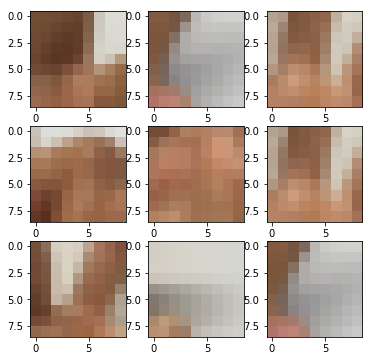

In [214]:
showActivationPortion(activateArray, params)

In [143]:
params['hparam_pool1']

{'f': 2, 'stride': 2}